# Task 3: Evaluación de Trade-offs y Decisiones Técnicas

## Integrantes
- Sergio Orellana 221122
- Rodrigo Mansilla 22611
- Ricardo Chuy 221007

---

## Contexto del Problema

**Producto A (Drone de Carreras):** Vuela a 80 km/h en interiores. Necesita estimar su posición (Odometría Visual) a 60 FPS mínimo. La calidad de la imagen es baja y borrosa.

**Producto B (Drone de Inspección de Grietas):** Vuela estático frente a presas hidroeléctricas. Toma fotos de altísima resolución (4K) para crear un mapa detallado (Stitching). El tiempo de procesamiento no es crítico, pero la precisión del emparejamiento debe ser milimétrica.

---
## Sección 1: Imports y Configuración

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

---
## Sección 2: Carga de Imágenes

In [ ]:
try:
    img1 = cv2.imread('./imgs/cereal_normal.jpg', cv2.IMREAD_GRAYSCALE)  
    img2 = cv2.imread('./imgs/cereal_rotado.jpg', cv2.IMREAD_GRAYSCALE)  
    
    if img1 is None or img2 is None:
        raise FileNotFoundError("No se encontraron las imágenes.")
    
    print(f"Imagen 1 cargada: {img1.shape}")
    print(f"Imagen 2 cargada: {img2.shape}")

except Exception as e:
    print(f"Error: {e}")

Imagen 1 cargada: (2268, 4032)
Imagen 2 cargada: (2268, 4032)


---
## Sección 3: Funciones Auxiliares (del Task 2)

In [13]:
def mostrar_matches(img1, kps1, img2, kps2, matches, nombre_algoritmo):
    """Visualiza los matches entre dos imágenes"""
    img_matches = cv2.drawMatches(img1, kps1, img2, kps2, matches, None, 
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title(f"{nombre_algoritmo}: {len(matches)} Matches Buenos")
    plt.axis('off')
    plt.show()

def filtrar_matches_lowe(matches_crudos, ratio=0.75):
    """Aplica el Ratio Test de David Lowe. Solo acepta un match si la distancia 
    del mejor candidato (m) es considerablemente menor que la del segundo mejor (n)."""
    buenos_matches = []
   
    for m, n in matches_crudos:
        if m.distance < ratio * n.distance:
            buenos_matches.append(m)
    return buenos_matches


---
## Sección 4: Implementación SIFT y ORB con Medición de Tiempo

In [ ]:
def ejecutar_sift_con_tiempo(img_original, img_alterada, ratio_lowes=0.75, n_iteraciones=10):
    """
    Ejecuta SIFT con medición de tiempos promedio.
    n_iteraciones: número de corridas para promediar (default 10)
    """
    resultados = {
        'algoritmo': 'SIFT',
        'tiempo_deteccion_ms': 0,
        'tiempo_matching_ms': 0,
        'tiempo_total_ms': 0,
        'keypoints_img1': 0,
        'keypoints_img2': 0,
        'matches_buenos': 0
    }
    
    tiempos_deteccion = []
    tiempos_matching = []
    
    #  detector SIFT
    detector = cv2.SIFT_create()
    
    kps1_final = None
    kps2_final = None
    desc1_final = None
    desc2_final = None
    good_matches_final = []
    
    print(f"Ejecutando SIFT ({n_iteraciones} iteraciones)...")
    
    for i in range(n_iteraciones):
        inicio_deteccion = time.perf_counter()
        
        kps1, desc1 = detector.detectAndCompute(img_original, None)
        kps2, desc2 = detector.detectAndCompute(img_alterada, None)
        
        fin_deteccion = time.perf_counter()
        
        tiempo_deteccion = (fin_deteccion - inicio_deteccion) * 1000
        tiempos_deteccion.append(tiempo_deteccion)
        
        if desc1 is None or desc2 is None:
            print("Error: SIFT no encontró descriptores.")
            return resultados
        
        # Medición Matching
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        
        inicio_matching = time.perf_counter()
        
        raw_matches = matcher.knnMatch(desc1, desc2, k=2)
        good_matches = filtrar_matches_lowe(raw_matches, ratio_lowes)
        
        fin_matching = time.perf_counter()
        tiempo_matching = (fin_matching - inicio_matching) * 1000
        tiempos_matching.append(tiempo_matching)
        
        if i == n_iteraciones - 1:
            kps1_final = kps1
            kps2_final = kps2
            desc1_final = desc1
            desc2_final = desc2
            good_matches_final = good_matches
            resultados['keypoints_img1'] = len(kps1)
            resultados['keypoints_img2'] = len(kps2)
            resultados['matches_buenos'] = len(good_matches)
    
    # Calcular promedios
    resultados['tiempo_deteccion_ms'] = np.mean(tiempos_deteccion)
    resultados['tiempo_matching_ms'] = np.mean(tiempos_matching)
    resultados['tiempo_total_ms'] = resultados['tiempo_deteccion_ms'] + resultados['tiempo_matching_ms']
    resultados['std_deteccion_ms'] = np.std(tiempos_deteccion)
    resultados['std_matching_ms'] = np.std(tiempos_matching)
    
    resultados['kps1'] = kps1_final
    resultados['kps2'] = kps2_final
    resultados['good_matches'] = good_matches_final
    
    print(f"=== SIFT (Promedio de {n_iteraciones} iteraciones) ===")
    print(f"Tiempo Detección + Descripción: {resultados['tiempo_deteccion_ms']:.2f} ± {resultados['std_deteccion_ms']:.2f} ms")
    print(f"Tiempo Matching: {resultados['tiempo_matching_ms']:.2f} ± {resultados['std_matching_ms']:.2f} ms")
    print(f"Tiempo Total: {resultados['tiempo_total_ms']:.2f} ms")
    print(f"Keypoints Imagen 1: {resultados['keypoints_img1']}")
    print(f"Keypoints Imagen 2: {resultados['keypoints_img2']}")
    print(f"Matches Buenos (post-Ratio Test): {resultados['matches_buenos']}")
    print()
    
    return resultados


In [ ]:
def ejecutar_orb_con_tiempo(img_original, img_alterada, ratio_lowes=0.75, n_iteraciones=10):
    """
    Ejecuta ORB con medición de tiempos promedio.
    """
    resultados = {
        'algoritmo': 'ORB',
        'tiempo_deteccion_ms': 0,
        'tiempo_matching_ms': 0,
        'tiempo_total_ms': 0,
        'keypoints_img1': 0,
        'keypoints_img2': 0,
        'matches_buenos': 0
    }
    
    tiempos_deteccion = []
    tiempos_matching = []
    
    detector = cv2.ORB_create(nfeatures=1000)
    
    kps1_final = None
    kps2_final = None
    good_matches_final = []
    
    print(f"Ejecutando ORB ({n_iteraciones} iteraciones)...")
    
    for i in range(n_iteraciones):
        inicio_deteccion = time.perf_counter()
        
        kps1, desc1 = detector.detectAndCompute(img_original, None)
        kps2, desc2 = detector.detectAndCompute(img_alterada, None)
        
        fin_deteccion = time.perf_counter()
        tiempo_deteccion = (fin_deteccion - inicio_deteccion) * 1000
        tiempos_deteccion.append(tiempo_deteccion)
        
        if desc1 is None or desc2 is None:
            print("Error: ORB no encontró descriptores.")
            return resultados
        
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        
        inicio_matching = time.perf_counter()
        
        raw_matches = matcher.knnMatch(desc1, desc2, k=2)
        good_matches = filtrar_matches_lowe(raw_matches, ratio_lowes)
        
        fin_matching = time.perf_counter()
        tiempo_matching = (fin_matching - inicio_matching) * 1000
        tiempos_matching.append(tiempo_matching)
        
        if i == n_iteraciones - 1:
            kps1_final = kps1
            kps2_final = kps2
            good_matches_final = good_matches
            resultados['keypoints_img1'] = len(kps1)
            resultados['keypoints_img2'] = len(kps2)
            resultados['matches_buenos'] = len(good_matches)
    
    resultados['tiempo_deteccion_ms'] = np.mean(tiempos_deteccion)
    resultados['tiempo_matching_ms'] = np.mean(tiempos_matching)
    resultados['tiempo_total_ms'] = resultados['tiempo_deteccion_ms'] + resultados['tiempo_matching_ms']
    resultados['std_deteccion_ms'] = np.std(tiempos_deteccion)
    resultados['std_matching_ms'] = np.std(tiempos_matching)
    
    resultados['kps1'] = kps1_final
    resultados['kps2'] = kps2_final
    resultados['good_matches'] = good_matches_final
    
    print(f"=== ORB (Promedio de {n_iteraciones} iteraciones) ===")
    print(f"Tiempo Detección + Descripción: {resultados['tiempo_deteccion_ms']:.2f} ± {resultados['std_deteccion_ms']:.2f} ms")
    print(f"Tiempo Matching: {resultados['tiempo_matching_ms']:.2f} ± {resultados['std_matching_ms']:.2f} ms")
    print(f"Tiempo Total: {resultados['tiempo_total_ms']:.2f} ms")
    print(f"Keypoints Imagen 1: {resultados['keypoints_img1']}")
    print(f"Keypoints Imagen 2: {resultados['keypoints_img2']}")
    print(f"Matches Buenos (post-Ratio Test): {resultados['matches_buenos']}")
    print()
    
    return resultados


---
## Sección 5: Ejecución de tiempos

Ejecutando SIFT (10 iteraciones)...
=== SIFT (Promedio de 10 iteraciones) ===
Tiempo Detección + Descripción: 5182.19 ± 764.58 ms
Tiempo Matching: 3014.78 ± 337.08 ms
Tiempo Total: 8196.97 ms
Keypoints Imagen 1: 15922
Keypoints Imagen 2: 12736
Matches Buenos (post-Ratio Test): 2876



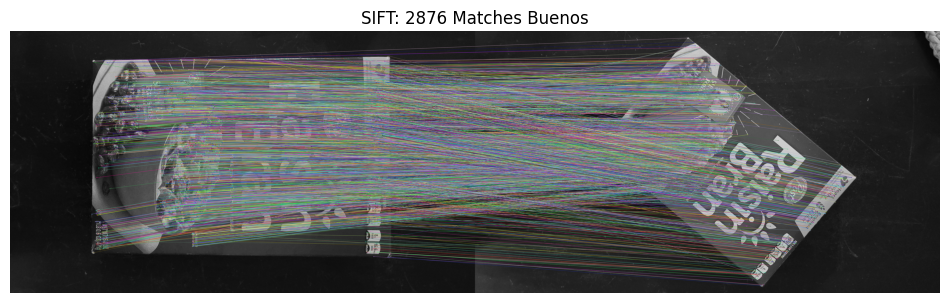

Ejecutando ORB (10 iteraciones)...
=== ORB (Promedio de 10 iteraciones) ===
Tiempo Detección + Descripción: 192.56 ± 24.61 ms
Tiempo Matching: 5.63 ± 0.78 ms
Tiempo Total: 198.20 ms
Keypoints Imagen 1: 1000
Keypoints Imagen 2: 1000
Matches Buenos (post-Ratio Test): 84



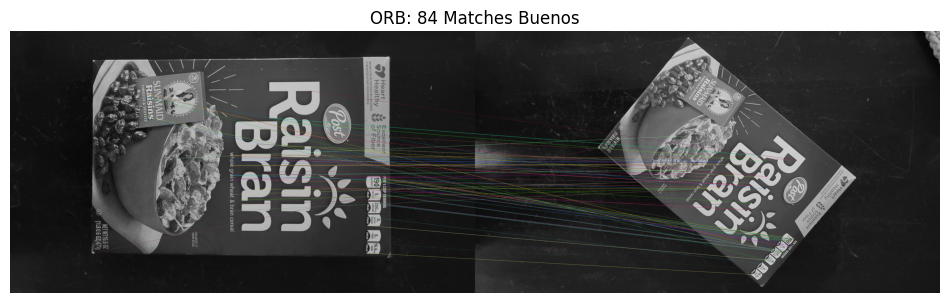

Algoritmo    | Tiempo Det (ms)  | Tiempo Match (ms)  | Tiempo Total (ms)  | KP Img A   | KP Img B   | Matches Buenos 
SIFT         | 5182.19          | 3014.78            | 8196.97            | 15922      | 12736      | 2876           
ORB          | 192.56           | 5.63               | 198.20             | 1000       | 1000       | 84             


In [ ]:
N_ITERACIONES = 10  
resultados_sift = ejecutar_sift_con_tiempo(img1, img2, ratio_lowes=0.75, n_iteraciones=N_ITERACIONES)

if resultados_sift['matches_buenos'] > 0:
    mostrar_matches(img1, resultados_sift['kps1'], img2, resultados_sift['kps2'], 
                    resultados_sift['good_matches'], "SIFT")

resultados_orb = ejecutar_orb_con_tiempo(img1, img2, ratio_lowes=0.75, n_iteraciones=N_ITERACIONES)

if resultados_orb['matches_buenos'] > 0:
    mostrar_matches(img1, resultados_orb['kps1'], img2, resultados_orb['kps2'], 
                    resultados_orb['good_matches'], "ORB")

print("=" * 90)
print(f"{'Algoritmo':<12} | {'Tiempo Det (ms)':<16} | {'Tiempo Match (ms)':<18} | {'Tiempo Total (ms)':<18} | {'KP Img A':<10} | {'KP Img B':<10} | {'Matches Buenos':<15}")
print("=" * 90)

print(f"{'SIFT':<12} | {resultados_sift['tiempo_deteccion_ms']:<16.2f} | {resultados_sift['tiempo_matching_ms']:<18.2f} | {resultados_sift['tiempo_total_ms']:<18.2f} | {resultados_sift['keypoints_img1']:<10} | {resultados_sift['keypoints_img2']:<10} | {resultados_sift['matches_buenos']:<15}")
print(f"{'ORB':<12} | {resultados_orb['tiempo_deteccion_ms']:<16.2f} | {resultados_orb['tiempo_matching_ms']:<18.2f} | {resultados_orb['tiempo_total_ms']:<18.2f} | {resultados_orb['keypoints_img1']:<10} | {resultados_orb['keypoints_img2']:<10} | {resultados_orb['matches_buenos']:<15}")

print("=" * 90)

---
## Sección 7: Tabla Comparativa de Resultados

In [25]:
import pandas as pd
from IPython.display import display, HTML

def crear_tabla_comparativa(resultados_list):
 
    data = []
    for r in resultados_list:
        data.append({
            'Algoritmo': r['algoritmo'],
            'Resolución': r.get('resolucion', f"{img1.shape[1]}x{img1.shape[0]}"),
            'Tiempo Detección (ms)': f"{r['tiempo_deteccion_ms']:.2f} ± {r.get('std_deteccion_ms', 0):.2f}",
            'Tiempo Matching (ms)': f"{r['tiempo_matching_ms']:.2f} ± {r.get('std_matching_ms', 0):.2f}",
            'Tiempo Total (ms)': f"{r['tiempo_total_ms']:.2f}",
            'Keypoints Img A': f"{r['keypoints_img1']:,}",
            'Keypoints Img B': f"{r['keypoints_img2']:,}",
            'Matches Buenos': f"{r['matches_buenos']:,}",
            'Eficiencia (Match/ms)': f"{r['matches_buenos']/r['tiempo_total_ms']:.2f}"
        })
    
    df = pd.DataFrame(data)
    
    styled = df.style\
        .set_properties(**{'text-align': 'center'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#2C3E50'), 
                                        ('color', 'black'), 
                                        ('font-weight', 'bold')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#0E0004')]}
        ])\
        .set_caption("Comparación de Rendimiento - SIFT vs ORB")
    
    display(HTML(styled.to_html(index=False)))
    return df

todos_resultados = [resultados_sift, resultados_orb]


tabla = crear_tabla_comparativa(todos_resultados)


,Algoritmo,Resolución,Tiempo Detección (ms),Tiempo Matching (ms),Tiempo Total (ms),Keypoints Img A,Keypoints Img B,Matches Buenos,Eficiencia (Match/ms)
0,SIFT,4032x2268,5182.19 ± 764.58,3014.78 ± 337.08,8196.97,"15,922","12,736","2,876",0.35
1,ORB,4032x2268,192.56 ± 24.61,5.63 ± 0.78,198.20,"1,000","1,000",84,0.42


---
## Sección 8: Análisis Crítico

### 8.1 Producto A: Drone de Carreras (60 FPS ≈ 16ms de presupuesto total)

**¿Cuál algoritmo elegiría para el Producto A y por qué?**

- *¿Cuál algoritmo cumple con el presupuesto de 16ms?*
- *¿Qué trade-offs hay entre velocidad y calidad de matches?*
- *¿Es aceptable la cantidad de matches "buenos" para odometría visual?*

Para el producto A , ningun algoritmo cumple el presupuesto de 16 ms con imagene4k. Sin embargo, de elegir uno, sería ORB, con reducción de resolución a VGA. Sift toma 8.2s y orb 198ms. Por lo que ORB es 41x más rápido que sift y escala linealmente con el área de la imagen. Sift es incompatible al tener una complejidad $O(n^2)$ del espacio de escalas DoG. 

Al escojer ORB se deben aceptar sus trade offs. Dentro de estos, el sacrificio de invarianza a la escala y rotaciones binarias para lograr la velocidad a traves de FAST y computando la distancia de Hamming. 


Los 84 matches de ORB en 4K son insuficientes para estimación de pose robusta. Sin embargo, en resolución VGA manteniendo el límite de 1000 keypoints, la densidad espacial sería adecuada para tracking visual, mientras que los 2876 matches de SIFT son teóricamente superiores pero inaccesibles por latencia. (Tareen & Saleem, 2018)

### 8.2 Producto B: Drone de Inspección de Grietas

**¿Cuál algoritmo elegiría para el Producto B y por qué?**

*TODO: Analizar la calidad visual de los matches en cambios de escala y rotación. Considerar:*
- *¿Cuál algoritmo produce matches más precisos y estables?*
- *¿Falló ORB en algún caso donde SIFT tuvo éxito?*
- *¿La invarianza a escala/rotación de SIFT es relevante para este caso?*
- *Si el tiempo no es crítico, ¿qué otros factores influyen en la decisión?*

---

La elección es SIFT, a pesar de no tener un tiempo crítico,genera aproximadamente 34 veces más la cantidad de matches que ORB, siendo esta precisión fundamental en la detección de estructuras de hormigón.

Con ORB, se obtuvieron matches por debajo del umbral necesario para estimar homografías en imagenes 4k , lo que representa una perdida de detalles estructurales.

La invarianza de SIFT es crítica, puesto que permite que el manejo de cambios de escala y perspectiva a traves del espacio de escallas DoG. ORB, por es debil ante invarianzas de escala.

Dentro de los factores diferentes que influyen en la desición esta la Densidad espacial, la precisión subpixel para las mediuciones milimétricasy la fortaleza de los algoritmos ante el ruido de alta frecuencia, especificamente en estructuras de concreto.

### 8.3 Generalización de Conclusiones

**¿Las conclusiones que estamos alcanzando son justas y generalizables? ¿Por qué? ¿Qué deberíamos considerar en futuras iteraciones?**

*TODO: Discutir limitaciones del experimento y mejoras para futuras iteraciones:*
- *¿Usamos suficientes imágenes de prueba?*
- *¿Las condiciones de iluminación y calidad de imagen son representativas?*
- *¿Cómo afectaría el hardware del drone los resultados?*
- *¿Qué otros algoritmos o variantes podrían considerarse?*
- *¿Cómo se comportarían ante motion blur o condiciones adversas?*

---

A partir de estas conclusiones, no es del todo posible generalizar de mánera completa una solución. Es necesario el uso de más imagenes que permitan la inferencia de un comportamiento estadístico. Las conclusiones entonces son validas en escenarios de alto contraste, no tanto en superficies homogeneas o repetitivas. 

Del mismo modo, las condiciones no son representativas, un laboratorio no presenta la misma iluminación que las que se tendrian en condiciones reales, donde SIFT es más sensible, así como tampoco se simula un motion blur que degrada los descriptores de ORB. 

Ambos tiempos pertenecen a CPU, en hardware ORB se beneficia más de las arquitecturas embebidas en los drones que SIFT. Por lo que en futuras iteraciones, es necesaria la toma de los factores que afectan a cada algoritmo y permitir un comportamiento estadistico mayor.

### Referencias

Mermer, S. (2023, febrero 19). SIFT vs ORB vs FAST: Performance Comparison of Feature Extraction Algorithms. Medium. https://medium.com/@siromermer/ 

sift-vs-orb-vs-fast-performance-comparison-of-feature-extraction-algorithms-d8993c977677
OpenDroneMap Community. (2018, enero 12). SIFT, SURF or ORB? OpenDroneMap Community Forum. https://community.opendronemap.org/t/sift-surf-or-orb/9357

Tareen, S. A. K., & Saleem, Z. (2018). A comparative analysis of SIFT, SURF, KAZE, AKAZE, ORB, and BRISK. arXiv preprint arXiv:1710.02726. https://arxiv.org/abs/1710.02726